# Example analysis notebook
### Author: Bill Flynn (bill.flynn@jax.org)

Major updates:
- 2018-09-28: creation
- 2018-12-10: reboot
- 2019-01-25: change import statement

In [1]:
from scanpy_recipes import sc

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Running Scanpy 1.3.7 on 2019-01-25 16:01.


## Loading data

In [2]:
ac = sc.AnalysisConfig()

In [5]:
config_string = """
[names]
customer_name = Anonymous person
analyst_name = Bill Flynn
analysis_name = Test-analysis

[sample_names]
PR18031 = Pancrease CD45-

[genomes]
PR18031 = GRCh38

[species]
hg19 = hsapiens
GRCh38 = hsapiens
mm10 = mmusculus

[input_dirs]
PR18031 = /projects/singlecellcore/2018_Projects/PR18031/

[output_dirs]
PR18031 = /fastscratch/flynnb/test-outputs
"""
config = ac.read(config_string)

In [6]:
adata_raw = sc.load_10x_data("PR18031", config)

reading /projects/singlecellcore/2018_Projects/PR18031/filtered_gene_bc_matrices_h5.h5 

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


(0:00:01.40)
Ran `.var_names_make_unique()` for you.


In [8]:
raw_save_file = sc.save_adata(adata_raw, "raw")

Saving PR18031-raw_20190108.h5ad to /fastscratch/flynnb/test-outputs.


## Quality control and filtering

Analysis first starts by generating **per-cell** and **per-gene** metrics, that we can then use to filter the data.

In [9]:
adata_raw = sc.read_h5ad(raw_save_file)

In [10]:
sc.qc.gen_qc(adata_raw)

hemoglobin_counts False
n_counts False
n_genes False
percent_mito False
sequencing_saturation False


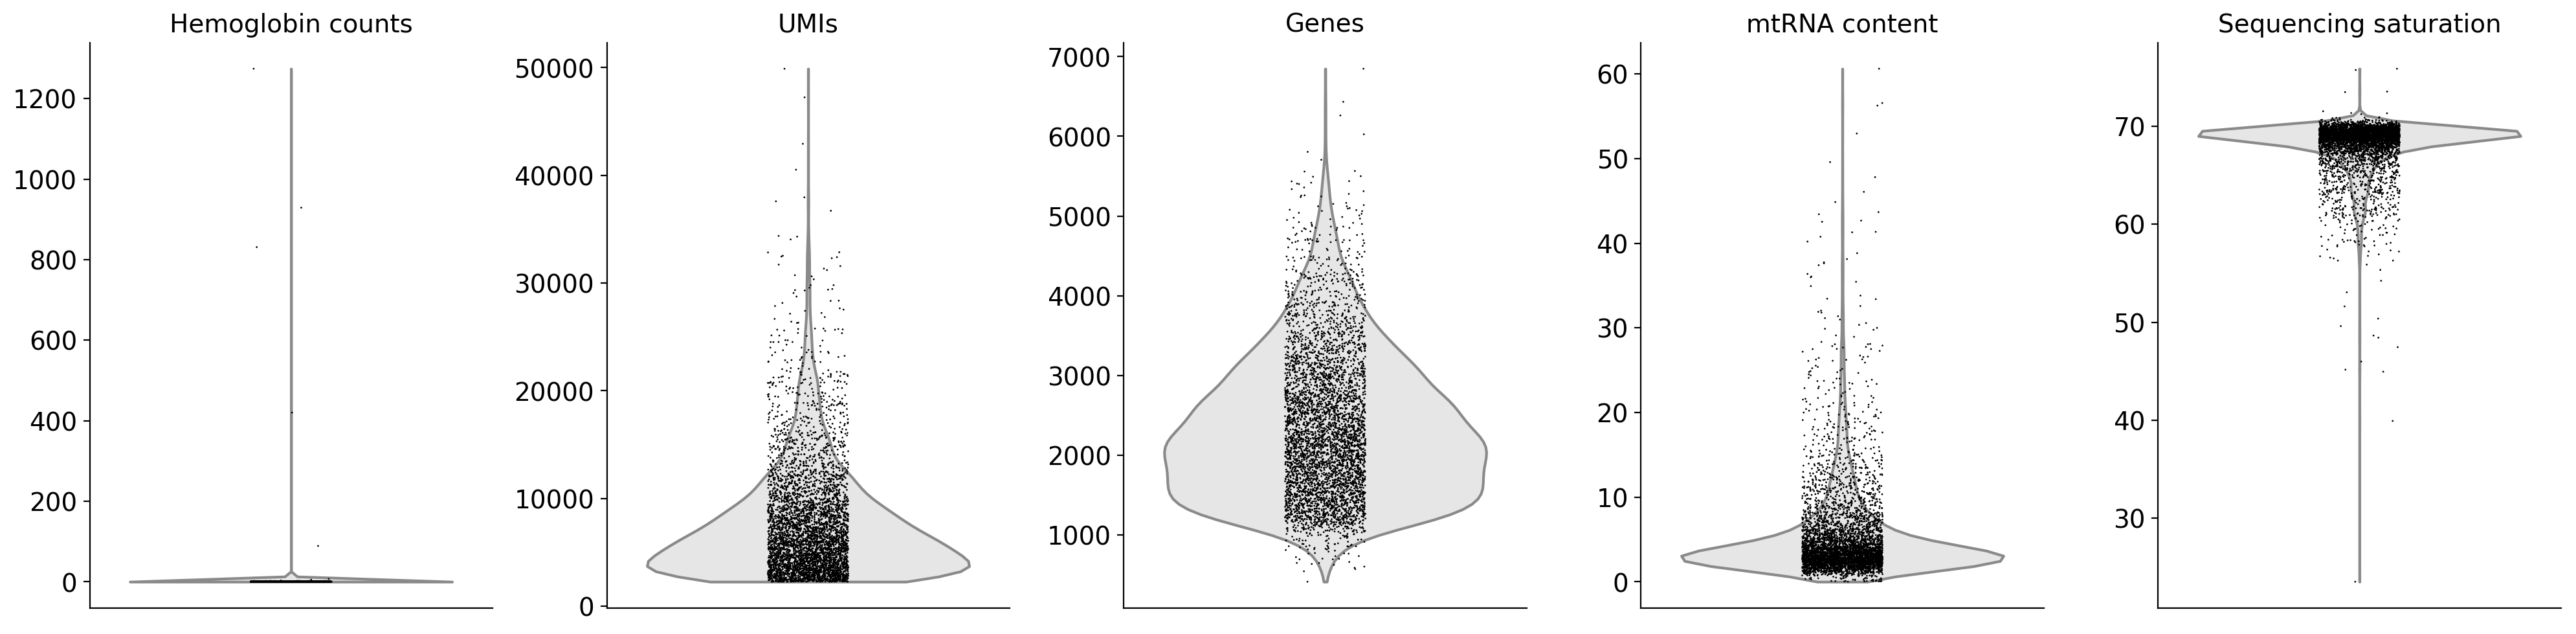

In [12]:
sc.pl.qc_violins(adata_raw)

In [13]:
qc_params = dict(
    min_cells_per_gene=3,
    min_counts_per_gene=3,
    min_counts_per_cell=1000,
    min_genes_per_cell=500,
    sequencing_saturation=None,
    percent_mito=20.0, 
    rbc_threshold=10
)

In [14]:
trial = sc.qc.run_qc(adata_raw, trial=True, **qc_params)

filtered out 13814 genes that are detected in less than 3 cells
filtered out 1 cells that have less than 500 genes expressed
Original dims: (4585, 33694)
Filtered dims: (4451, 19880)


In [15]:
trial.obs.qc_fail.value_counts()

pass    4451
fail     134
Name: qc_fail, dtype: int64

hemoglobin_counts 10
n_counts 1000
n_genes 500
percent_mito 20.0
sequencing_saturation None


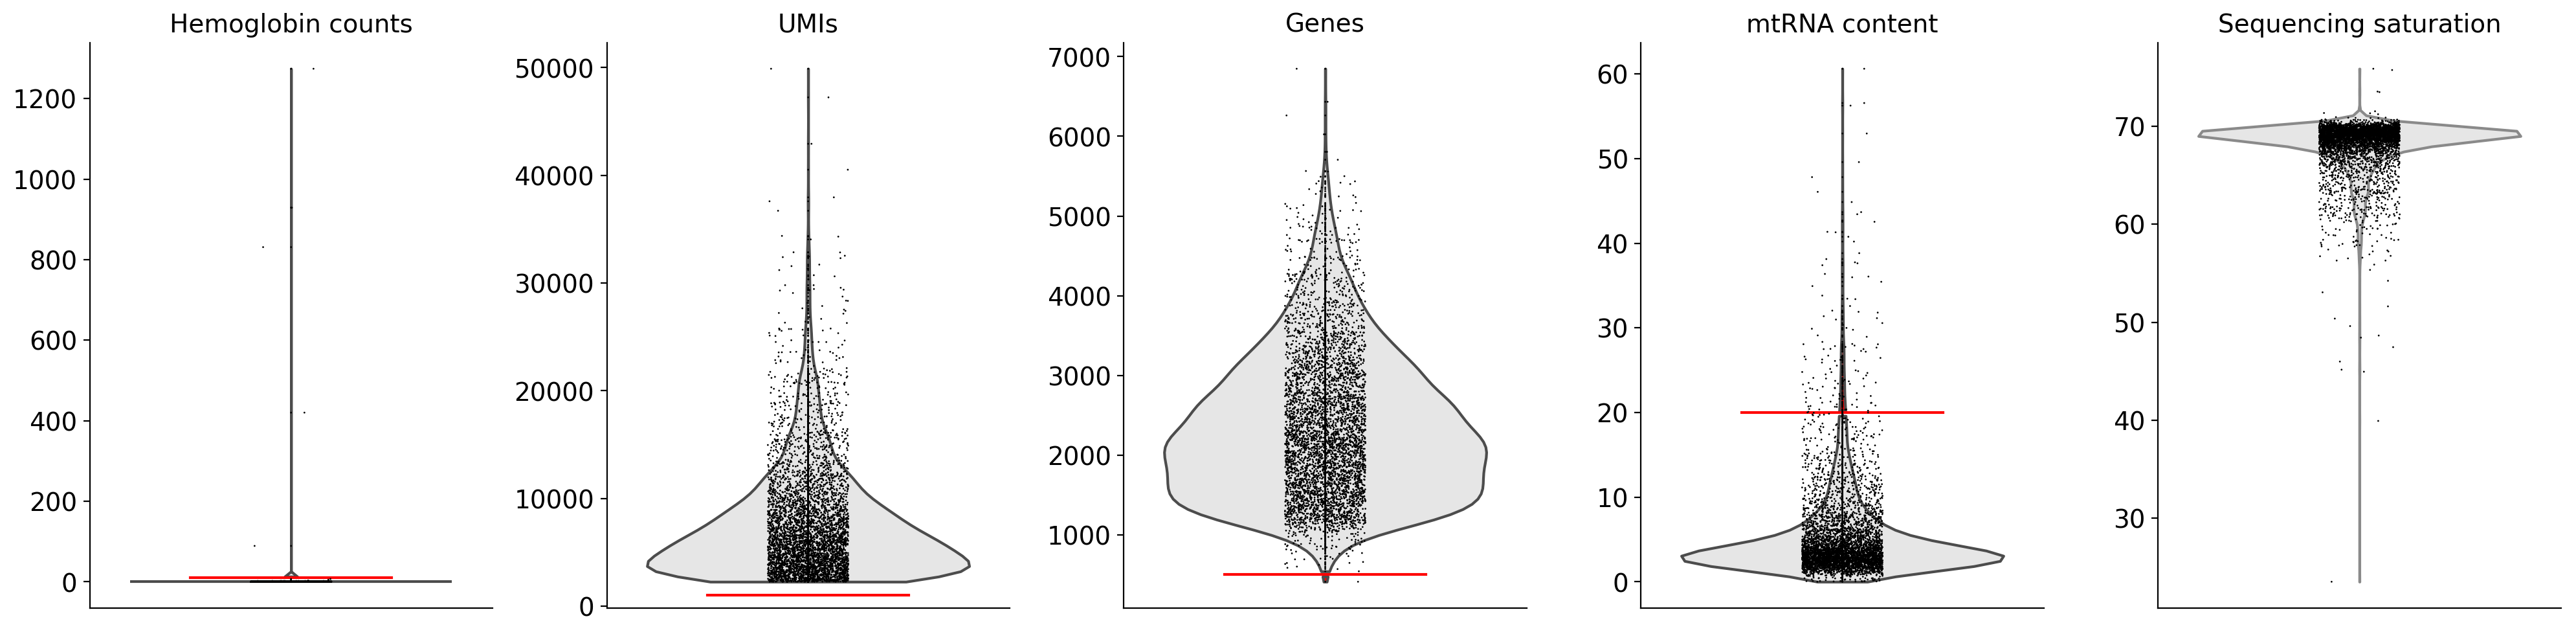

In [16]:
qc_fig1 = sc.pl.qc_violins(trial, return_fig=True)

In [17]:
trial = sc.qc.run_qc(adata_raw, trial=True, **qc_params)
adata_qc = sc.qc.run_qc(adata_raw, trial=False, **qc_params)

filtered out 13814 genes that are detected in less than 3 cells
filtered out 1 cells that have less than 500 genes expressed
Original dims: (4585, 33694)
Filtered dims: (4451, 19880)
filtered out 13814 genes that are detected in less than 3 cells
filtered out 1 cells that have less than 500 genes expressed
Original dims: (4585, 33694)
Filtered dims: (4451, 19880)


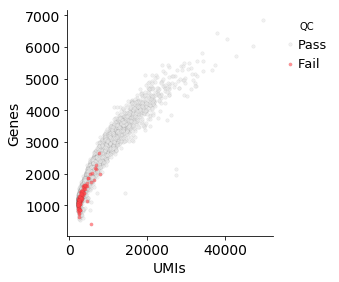

In [19]:
qc_fig2 = sc.pl.qc_pass_fail(trial, return_fig=True)

reading /projects/singlecellcore/2018_Projects/PR18031/raw_gene_bc_matrices_h5.h5 

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


(0:00:02.68)


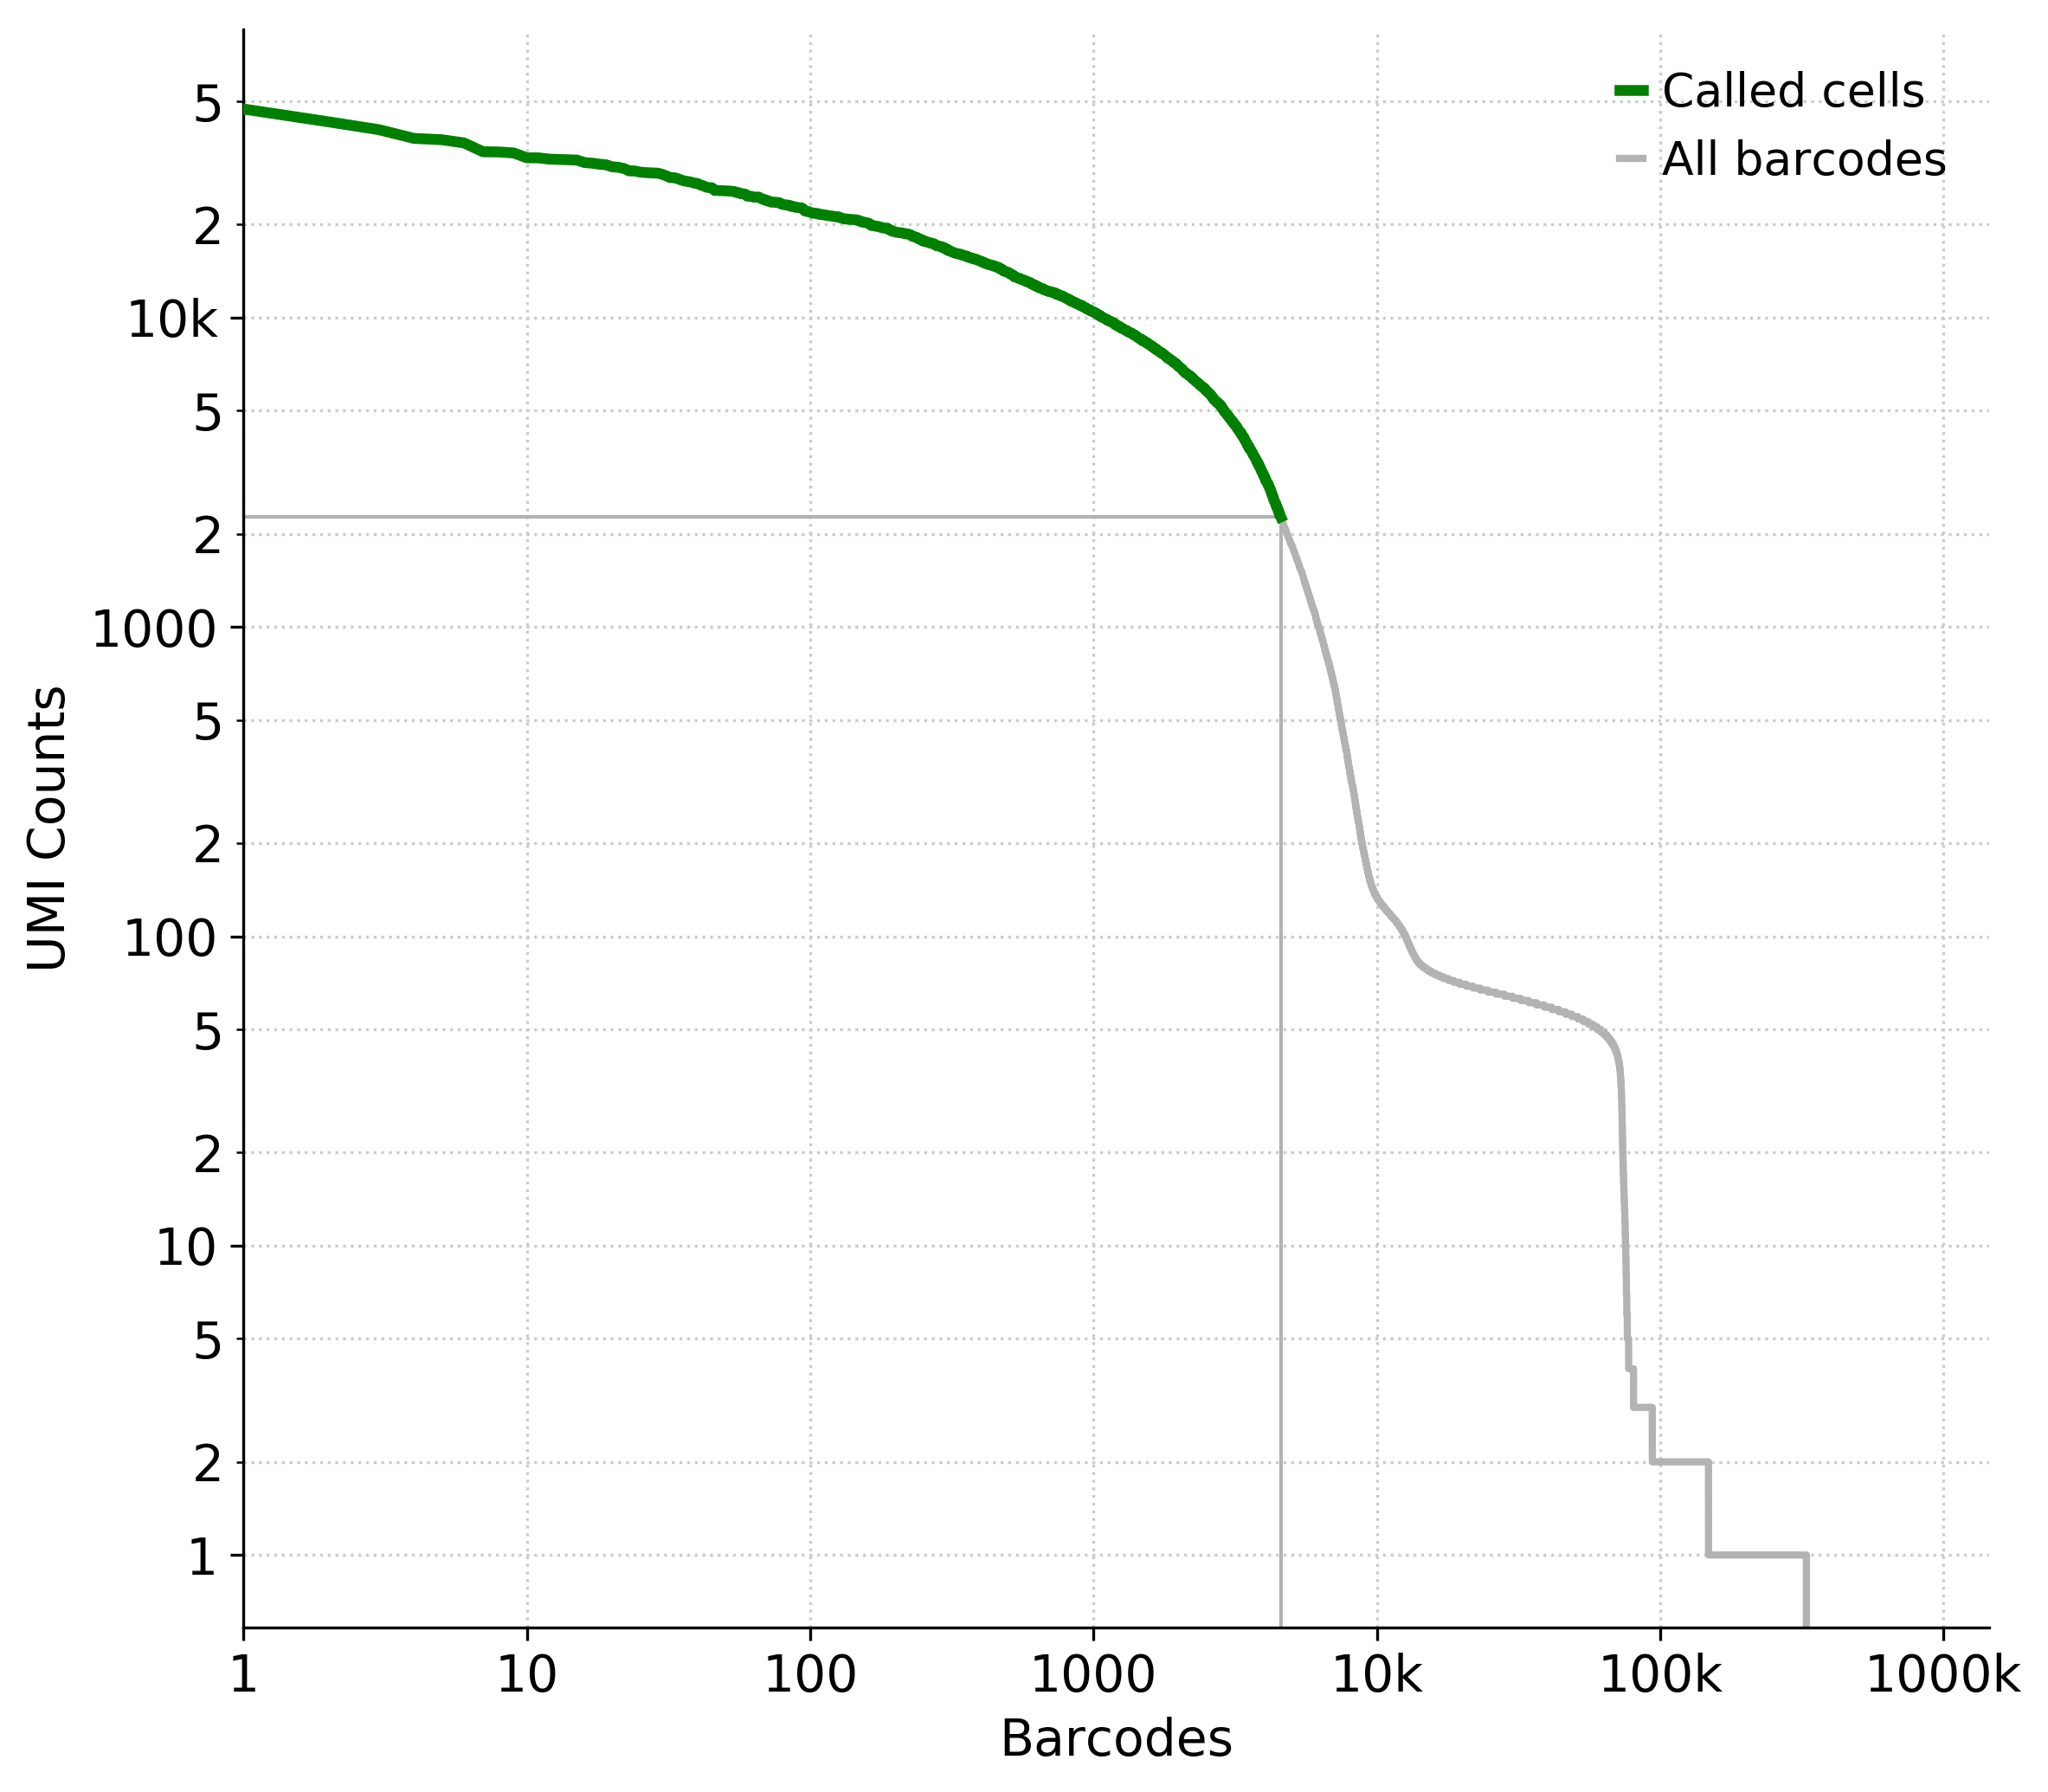

In [20]:
qc_fig3 = sc.pl.umi_rank_plot(adata_raw, return_fig=True)

This will ultimately become part of the report, but for now we can print out the QC filterering stats.

In [21]:
qc_message = (
    "After QC, the cell-gene matrix contains {cells} cells and {genes} genes.\n"
    "1.  {low_count_genes_removed} were removed due to too few counts.\n"
    "2.  {cells_removed} were removed due to several factors.\n"
    "2a.  {low_count_cells_removed} were removed due to low UMI and gene counts.\n"
    "2b.  {red_blood_cells_removed} were removed due to high counts of hemoglobin markers.\n"
    "2c.  {high_mtrna_cells_removed} were removed due to high mtRNA content.\n"
    "2d.  {low_sequencing_saturation_cells_removed} were removed due to low per-cell sequencing saturation.\n")
print(qc_message.format(**trial.uns["qc_metrics"]))

After QC, the cell-gene matrix contains 4451 cells and 19880 genes.
1.  13814 were removed due to too few counts.
2.  134 were removed due to several factors.
2a.  0 were removed due to low UMI and gene counts.
2b.  5 were removed due to high counts of hemoglobin markers.
2c.  128 were removed due to high mtRNA content.
2d.  0 were removed due to low per-cell sequencing saturation.



In [22]:
qc_save_file = sc.save_adata(adata_qc, "qc")

Saving PR18031-qc_20190108.h5ad to /fastscratch/flynnb/test-outputs.


## Highly variable gene selection and dimensionality reduction

In [23]:
adata_qc = sc.read_h5ad(qc_save_file)

In [24]:
adata_full, adata_redux = sc.pp.preprocess(adata_qc, n_top_genes=1000, scale=True)

If you pass `n_top_genes`, all cutoffs are ignored.


In [26]:
sc.pp.dimensionality_reduction(adata_redux, n_neighbors=10, min_dist=0.5)

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished (0:00:09.41) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:10.80) --> added
    'X_umap', UMAP coordinates (adata.obsm)
computing UMAP
    finished (0:00:09.71) --> added
    'X_umap', UMAP coordinates (adata.obsm)
2D UMAP available at `.obsm['X_umap']`
3D UMAP available at `.obsm['X_umap_3d']`


## Clustering

In [28]:
sc.tl.cluster(adata_redux, )

running Leiden clustering
    finished (0:00:00.78) --> found 25 clusters and added
    'cluster', the cluster labels (adata.obs, categorical)


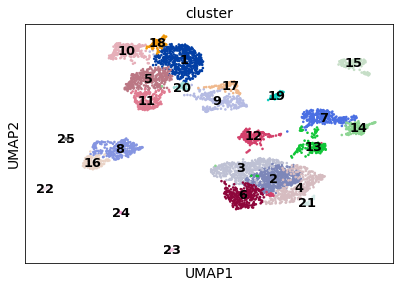

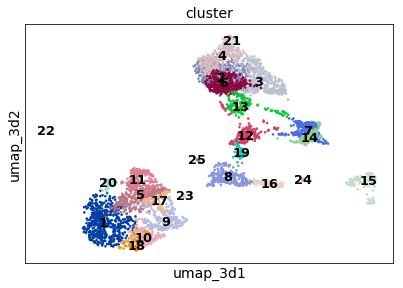

In [29]:
sc.pl.scatter(adata_redux, basis="umap", color="cluster", legend_loc="on data")
sc.pl.scatter(adata_redux, basis="umap_3d", color="cluster", legend_loc="on data")

In [30]:
sc.tl.subcluster(adata_redux, cluster="13", cluster_key="cluster")

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.02) --> found 3 clusters and added
    'cluster_R1', the cluster labels (adata.obs, categorical)
Updated clusters under `adata_redux.obs['cluster_R1']`.


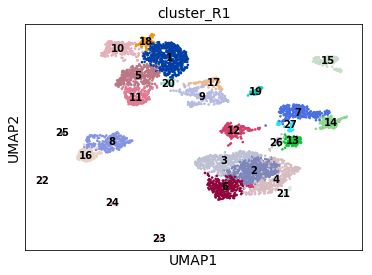

In [31]:
sc.pl.umap(adata_redux, color="cluster_R1", legend_loc="on data")

## Marker gene detection

In [33]:
markers = sc.tl.find_marker_genes(adata_redux, "cluster_R3", log_fold_change=1.0)

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 
Computed markers for 32 clusters.


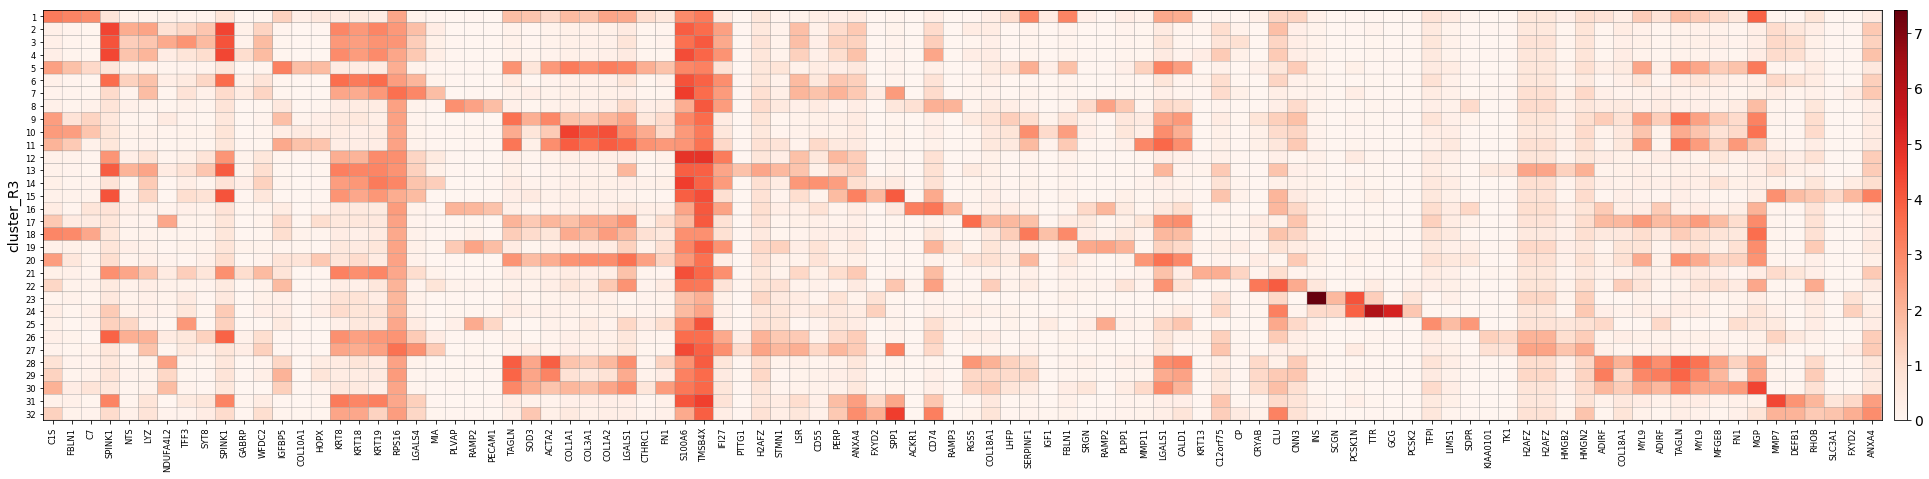

In [35]:
top3_genes = markers.groupby("cluster_R3").head(3).gene_name.values
sc.pl.matrixplot(adata_redux, top3_genes, groupby="cluster_R3", log=True)
#sc.pl.dotplot(adata_redux, top3_genes, groupby="cluster_R3", log=True)
#sc.pl.heatmap(adata_redux, top3_genes, groupby="cluster_R3", log=True)

In [36]:
sc.export_markers(adata_redux, "cluster_R3")

CSV file saved to [/fastscratch/flynnb/test-outputs/PR18031_markers_20190108.csv].
Excel file saved to [/fastscratch/flynnb/test-outputs/PR18031_markers_20190108.xlsx].


## Report generation

Report generation happens in 5 steps.
1. Create a temport directory for report-related files
2. Generate and save report quality QC figures.
3. Generate and save intro and metrics page.
4. Copy over CellView documentation (TBD).
5. Combine to produce single report.

In [42]:
report = sc.SCBLReport()

In [47]:
report.add_report_figures(adata_redux, 
                          violins=qc_fig1, 
                          scatters=qc_fig2,
                          ranks=[qc_fig3],
                          cluster_key="cluster")#_R3")

In [48]:
adata_redux.uns["10x_metrics"]["sample"]["Sequencing Saturation"] = 1

In [49]:
report.generate_report(adata_redux)

HTML report saved to [/fastscratch/flynnb/test-outputs/PR18031_20190108_report.html].


In [ ]:
report.generate_pdf()

## Saving outputs

In [ ]:
sc.save_adata_to_rds(adata_redux, cluster_key="cluster_R3")

In [ ]:
full_save_file = sc.save_adata(adata_full, "full")
redux_save_file = sc.save_adata(adata_redux, "redux")
# OR
#sc.save_all_adata()

In [56]:
for k in adata_redux.obs.iterrows():
    print(k)
    break

('AAACCTGAGGCCATAG-1', sequencing_saturation    90.4003
percent_mito              2.7464
hemoglobin_counts              0
n_counts                 804.501
n_genes                     3116
n_counts_total             12307
cluster                       14
cluster_R1                    14
cluster_R2                    14
cluster_R3                    14
Name: AAACCTGAGGCCATAG-1, dtype: object)
